[View in Colaboratory](https://colab.research.google.com/github/jpskycak/research_notebooks/blob/master/programmable_self_assembly_into_non_simply_connected_shapes.ipynb)

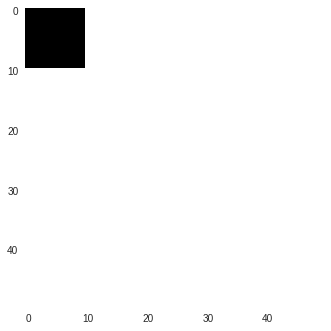

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import uuid

# initial coordinates for agents
L = 10
gridshape = (5*L,5*L)
grid = np.zeros(gridshape)
grid[:L,:L] = 1
plt.imshow(grid)
plt.grid(False)
plt.show()

In [18]:
# instantiate agents at initial coordinates
# initialize estimated coordinates as true initial coordinates
# update_neighbors_and_distances()

agents = [{'true_coordinates':(x,y),'estimated_coordinates':(x,y),'id':str(uuid.uuid4())} for x in range(gridshape[0]) for y in range(gridshape[1]) if grid[x,y]==1]

def distance_metric(a,b):
  return max(abs(a[0]-b[0]),abs(a[1]-b[1]))

def in_radius(test_point,center,radius):
  out = False
  if distance_metric(test_point,center) <= radius:
    out = True
  return out

def get_neighbors_and_distances(agent,radius=1):
  center = agent['true_coordinates']
  neighbors = [i for i,a in enumerate(agents) if in_radius(a['true_coordinates'],center,radius) and a['id'] != agent['id']]
  distances = [distance_metric(agents[i]['true_coordinates'],center) for i in neighbors]
  return [neighbors,distances]

def update_neighbors_and_distances():
  for a in agents:
    [neighbors,distances] = get_neighbors_and_distances(a)
    a['neighbors'] = neighbors
    a['distances'] = distances


update_neighbors_and_distances()
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (0, 0),
 'id': '5328bb79-0b46-4ac8-95e1-a411b1587990',
 'neighbors': [1, 10, 11],
 'true_coordinates': (0, 0)}

In [19]:
# initialize gradient values. source agent is at (L-1,L-1)

for a in agents:
  if a['true_coordinates'] == (L-1,L-1):
    a['gradient_value'] = 0
    for neighbor_index in a['neighbors']:
      neighbor = agents[neighbor_index]
      neighbor['gradient_value'] = 1
      
def do_all_agents_have_gradient_values():
  ans = True
  for a in agents:
    if 'gradient_value' not in a.keys():
      ans = False
  return ans

while not do_all_agents_have_gradient_values():
  for a in agents:
    if 'gradient_value' not in a.keys():
      neighbors = [agents[i] for i in a['neighbors']]
      min_gradient_in_neighbors = 9*10**10
      should_assign_gradient_value = False
      for neighbor in neighbors:
        if 'gradient_value' in neighbor.keys():
          min_gradient_in_neighbors = min(neighbor['gradient_value'],min_gradient_in_neighbors)
          should_assign_gradient_value = True
      if should_assign_gradient_value:
        a['gradient_value'] = 1+min_gradient_in_neighbors
  
agents[0]

{'distances': [1, 1, 1],
 'estimated_coordinates': (0, 0),
 'gradient_value': 9,
 'id': '5328bb79-0b46-4ac8-95e1-a411b1587990',
 'neighbors': [1, 10, 11],
 'true_coordinates': (0, 0)}

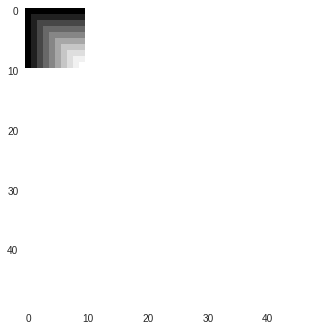

In [20]:
# check gradient
gradient = np.zeros(gridshape)
for a in agents:
  [x,y] = a['true_coordinates']
  gradient[x,y] = a['gradient_value']
  
plt.imshow(gradient)
plt.grid(False)
plt.show()

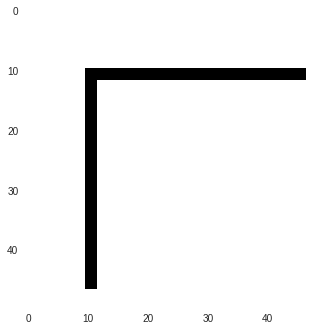

[(10, 10), (10, 11), (10, 12), (10, 13), (10, 14)]

In [21]:
# make shape
shape = np.zeros(gridshape)
shape[L:-3,L:-3] = 1
shape[int(1.25*L):-3,int(1.25*L):-3] = 0 

plt.imshow(shape)
plt.grid(False)
plt.show()

shape_coordinates = []
for x in range(shape.shape[0]):
  for y in range(shape.shape[1]):
    if shape[x,y] == 1:
      shape_coordinates.append((x,y))
shape_coordinates[:5]

In [0]:
# timestep:
# 1. all agents edge-follow one step if able.
# 2. compute_neighbors_and_distances(),
# 3. recompute gradient and estimated coordinates
# (as those which minimize the discrepancy between the observed distances to neighbors
# and the distances calculated using neighbors' estimations of their own coordinates)

In [34]:
# edge-follow

def thinks_its_in_shape(agent):
  if agent['estimated_coordinates'] in shape_coordinates:
    return True
  else:
    return False

def nearest_points_in_shape(agent):
  distances = [distance_metric(agent['estimated_coordinates'],p) for p in shape_coordinates]
  return [shape_coordinates[i] for i,d in enumerate(distances) if d==min(distances)]

def one_neighbors(agent):
  return [n for i,n in enumerate(agent['neighbors']) if agent['distances'][i]==1]

def available_moves(agent):
  # can move if distance to point is 1 and point is not occupied and moving
  # would not leave a 1-neighbor without any 1-neighbors itself
  def is_in_grid(coord):
    if coord[0]>=0 and coord[1]>=0:
      try:
        x = grid[coord]
        return True
      except:
        return False
    else:
      return False
  
  def is_occupied(coord):
    return bool(grid[coord])
  
  def is_isolating_move(agent,prospective_move):
    agent_after_move = agent
    agent_after_move['true_coordinates'] = move
    one_neighbors_after_move = get_neighbors_and_distances(agent,radius=1)[0]
    if len(one_neighbors_after_move) == 0:
      return True
    else:
      return False
  
  def is_abandoning_move(agent,prospective_move):
    # if agent is only neighbor for some 1-neighbor
    # if moving would remove that 1-neighbor from agent's neighbors
    one_neighbors_for_which_agent_is_only_neighbor = []
    for i in one_neighbors(agent):
      neighbor = agents[i]
      if len(neighbor['neighbors']) == 1:
        one_neighbors_for_which_agent_is_only_neighbor.append(i)
    
    if len(one_neighbors_for_which_agent_is_only_neighbor)==0:
      return False
    else:
      out = False
      for i in one_neighbors_for_which_agent_is_only_neighbor:
        neighbor = agents[i]
        if distance_metric(prospective_move,neighbor['true_coordinates'])>1:
          out = True
          break
      return out

  (x,y) = agent['true_coordinates']
  candidate_moves = [(x+1,y),(x-1,y),(x,y+1),(x,y-1),
                    (x+1,y+1),(x+1,y-1),(x-1,y+1),(x-1,y-1)]
  available_moves = []
  for move in candidate_moves:
    if is_in_grid(move):
      if not is_occupied(move):
        if not is_isolating_move(agent,move):
          if not is_abandoning_move(agent,move):
            available_moves.append(move)
        
  return available_moves

print available_moves(agents[0])
print available_moves(agents[-1]) 

[]
[(10, 9), (9, 10), (10, 8), (8, 10)]


In [31]:
def best_moves(agent):
  # how far to shape after a given move?
  available_moves(agent)
  nearest_point_in_shape(agent)

#def prospective_movement(agent):
#  nearest_points = nearest_points_in_shape
#  (x,y)=agent['estimated_coordinates']
  #nearest_
  # clockwise edge-following

{'distances': [1, 1, 1],
 'estimated_coordinates': (9, 9),
 'gradient_value': 0,
 'id': '3b9f59ef-f8fa-4a0d-a9e4-1ac6cb60d00d',
 'neighbors': [88, 89, 98],
 'true_coordinates': (9, 9)}